In [ ]:
# Mounting Google-Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# CELL 1

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

import re, os, math, sklearn, datetime, pickle

from tqdm import tqdm

In [ ]:
df_com = pd.read_csv('/content/gdrive/MyDrive/Capstone/common_movies.csv', index_col = 0)

In [ ]:
movies_df = pd.read_csv('/content/gdrive/MyDrive/Capstone/ml-25m/movies.csv')
movies_df = pd.merge(df_com[['movieId', 'Emotion']], movies_df,
                     how = 'right',
                     on = ['movieId'])
ratings_df = pd.read_csv('/content/gdrive/MyDrive/Capstone/ml-25m/ratings.csv').iloc[:500000, :]
#ratings_df = pd.merge(ratings_df, df_com['movieId'],
#                      how = 'inner',
#                      on=['movieId'])
tags_df = pd.read_csv('/content/gdrive/MyDrive/Capstone/ml-25m/tags.csv')
#tags_df = pd.merge(tags_df, df_com['movieId'],
#                      how = 'inner',
#                      on=['movieId'])

In [ ]:
movies_df['genres'] = movies_df['genres'].str.cat(movies_df['Emotion'],
                                                  sep = '|', na_rep = 'remove')
movies_df.drop('Emotion', axis = 1, inplace = True)
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy|re...
1,2,Jumanji (1995),Adventure|Children|Fantasy|remove
2,3,Grumpier Old Men (1995),Comedy|Romance|remove
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance|remove
4,5,Father of the Bride Part II (1995),Comedy|remove
...,...,...,...
62418,209157,We (2018),Drama|remove
62419,209159,Window of the Soul (2001),Documentary|remove
62420,209163,Bad Poems (2018),Comedy|Drama|remove
62421,209169,A Girl Thing (2001),(no genres listed)|remove


In [ ]:
movies_df['genres'] = movies_df['genres'].str.replace("\|remove", "")
movies_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [ ]:
# Moving the data out of ratings_df and tags_df for the last movie the user liked to be used as the label:
## Rating of 4+ = liked

if os.path.exists('data/') != True:
    os.mkdir('data/')
    
if os.path.exists('data/last_liked_tags/') != True: 
    os.mkdir('data/last_liked_tags/')
    
# Getting the last movie liked from ratings_df:
ratings_df_copy = ratings_df.copy()
tags_df_copy = tags_df.copy()

users_list = ratings_df_copy['userId'].unique().tolist() ## List of all users in the dataset

ratings_index_list = [] ## These empty lists will be used to remove the last liked movies from the ratings_df and tags_df_mod copies
tags_index_list = []

last_ratings_df = pd.DataFrame() ## Want to save all the last liked movies rated into a single CSV file

counter = 0

for user in tqdm(users_list):
    try: ## Some users did not rate a movie highly enough and will be removed from the dataset
        temp_df = ratings_df_copy[ratings_df_copy.userId == user].copy()
        temp_df = temp_df[temp_df.rating >= 4] # = Liked Movie

        last_time = max(temp_df.timestamp) ## If the user did not have a "liked" movie, this will return an error

        temp_df = temp_df[temp_df.timestamp == last_time] ## Isolating the last liked movie rated for each user
        
        if len(temp_df) > 1: ## Some of the movies were rated at the same timestamp; only the last one on spliced DF will be removed
            temp_df = temp_df.iloc[[len(temp_df)-1]]
            
        ratings_index_list.append(temp_df.index.values[0]) ## Appending the index of the last movies watched

        if counter == 0:
            last_ratings_df = temp_df
            counter = 1

        else:
            last_ratings_df = pd.concat([last_ratings_df, temp_df], ignore_index= True)
        
    except Exception:
        ratings_index_list.append(ratings_df_copy[ratings_df_copy.userId == user].index.values[0]) ## Adding the index of the users whom did not highly rate a movie
    
    try:  ## Some users have not created tags
        temp_df = tags_df_copy[tags_df_copy.userId == user].copy()
        temp_df = temp_df[temp_df.rating >= 4]
        last_movie = temp_df.movieId.values[0]
        temp_df = temp_df[temp_df.movieId == last_movie]
        
        
        if len(temp_df) == 0:
            continue
            
        else:
            temp_df.to_csv('data/last_liked_tags/' + str(user) + '.csv', index = False)  ###!!! THESE TAGS WILL NOT BE USED AND IS STORED FOR EXAMINATION PURPOSES; these must be removed for "proper" datasets when training to exclude data related to the label from being used in the training data
            tags_index_list.extend(list(temp_df.index.values))  ## This is a .extend since there are most likely more than one timestamp per movie
    
    except Exception:
        pass
    
last_ratings_df.to_csv('data/last_liked_ratings.csv', index = False)

# Removing the last movies from ratings_df_copy and tags_df_copy:
ratings_df_removed = ratings_df_copy.drop(ratings_index_list)

tags_df_removed = tags_df_copy.drop(tags_index_list)

ratings_df_removed.to_csv('data/ratings_df_last_liked_movie_removed.csv', index = False)
tags_df_removed.to_csv('data/tags_df_last_liked_movie_removed.csv', index = False)

100%|██████████| 3445/3445 [00:17<00:00, 200.36it/s]


In [ ]:
'''
	tags.csv (remove timestamp column)
		- Lower case all tags
		- Remove tags with 1-2 letter words and remove parenthesis from the tags
			These are opinions/more like mini-reviews
			It will be hard to compare these into same catagories 
			KEEP ALL TAGS WTIH "based"
		- Create a new DataFrame
			Associate each movie to the tags (ignoring/removing the userId)
				Then add all same tags together
		- Create a new DF
			Associate each userId with all the tags they inputted
				Count all the tags
						Thinking is that the tag with the most counts will be the subject/genre/type that the user likes to watch the most
						(Goal for this DF is to describe the user)
'''

## Deleting 'timestamp' column
## Droping NaN values
tags_df_removed = pd.read_csv('data/tags_df_last_liked_movie_removed.csv')

tags_df_mod = tags_df_removed.copy().drop('timestamp', axis=1).dropna()
# Making all tags lowercased for uniform format
tags_df_mod['tag'] = tags_df_mod['tag'].str.lower()


for index, row in tags_df_mod.iterrows():
    ## splitting words for spell check
    tag = row.tag#.split()
    
    ## Removing all parenthesis and its contents, including the whitespace before
    correct_tag = re.sub(r' \([^)]*\)', '', tag)
    
    ## This is necessary because it is a common tag and avoids the other if statements downstream
    if 'based' in correct_tag:
        tags_df_mod.loc[index, 'tag'] = correct_tag
        continue
    
    ## This is to keep "sci-fi" from being removed in the next if statement
    if '-' in correct_tag:
        tags_df_mod.loc[index, 'tag'] = correct_tag
        continue
        
    if re.findall(r'\b\w{2}\b', correct_tag):
        ## Removing two-letter words
        tags_df_mod.loc[index, 'tag'] = np.NaN
        
    elif re.findall(r'\b\w{1}\b', correct_tag):
        ## Replacing one-letter words
        tags_df_mod.loc[index, 'tag'] = np.NaN
        
    elif tag == correct_tag:
        continue
        
    else:
        ## Saving Corrected Tag
        tags_df_mod.loc[index, 'tag'] = correct_tag
        pass

# Dropping tags with less than 2 letters
tags_df_mod = tags_df_mod.dropna()

tags_df_mod.to_csv('data/tags_df_mod.csv', index = False)
        

In [ ]:
# Storing most common tags for each movie ("movieId"):
    
if os.path.exists('data/movie_tags/') != True: # Creating movie_tags subfolder
    os.mkdir('data/movie_tags/')
    
tags_df_mod = pd.read_csv('data/tags_df_mod.csv')

tags_df_no_user = tags_df_mod.copy().drop('userId', axis= 1)

## Obtaining a list of all movieId with tags:
movieId_list = list(set(tags_df_no_user.movieId))  

for movieId in movieId_list:
    df_select = tags_df_no_user[tags_df_no_user.movieId == movieId].copy().drop('movieId', axis= 1)
    
    df_select['COUNT'] = 1
    
    df_select_group = df_select.groupby(['tag']).count()
    
    df_select_group = df_select_group.sort_values(by=['COUNT'], ascending= False).reset_index()
    
    df_select_group.to_csv('data/movie_tags/' + str(movieId) + '.csv', index = False)

In [ ]:
# Creating a new DF that contains the most common tags for each user ("userId"):

if os.path.exists('data/user_tags/') != True:
    os.mkdir('data/user_tags/')
    
## Creating a copy of tags_df_mod and dropping userID:
tags_df_mod = pd.read_csv('data/tags_df_mod.csv')

tags_df_user = tags_df_mod.copy().drop('movieId', axis= 1)

## Obtaining a list of all movieId with tags:
userId_list = list(set(tags_df_user.userId))

for userId in userId_list:
    df_select = tags_df_user[tags_df_user.userId == userId].copy().drop('userId', axis= 1)
    
    df_select['COUNT'] = 1
    
    df_select_group = df_select.groupby(['tag']).count()
    
    df_select_group = df_select_group.sort_values(by=['COUNT'], ascending= False).reset_index()
    
    df_select_group.to_csv('data/user_tags/' + str(userId) + '.csv', index = False)

In [ ]:
# Creating another DF that contains the most common tags created by users:
## Common = the tag was used 35 times or more
tags_df_mod = pd.read_csv('data/tags_df_mod.csv')

common_tags_df = tags_df_mod.groupby(['tag']).count().sort_values('userId', ascending= False).copy().drop('movieId', axis= 1).reset_index()

common_tags_df = common_tags_df[common_tags_df.userId >= 35]

common_tags_df.to_csv('data/common_tags.csv', index = False)

In [ ]:
'''
movies.csv
		- Move all years to its own Year column
		- Expand all genres into their own columns and use 0 & 1 as no or yes
			REMOVE "IMAX" from genre
		- Add average user rating from ratings.csv (include average + std & average - std)
			Also add number of users who watched the movie
'''
ratings_df_removed = pd.read_csv('data/ratings_df_last_liked_movie_removed.csv')
movies_df_mod = movies_df.copy()

movies_df_mod['YEAR'] = 0
movies_df_mod['UPPER_STD'] = 0
movies_df_mod['LOWER_STD'] = 0
movies_df_mod['AVG_RATING'] = 0
movies_df_mod['VIEW_COUNT'] = 0

# Making the genres into columns:
## First, need to obtain a list of all the genres in the dataset.
genres_list = []
for index, row in movies_df.iterrows():
    try:
        genres = row.genres.split('|')
        genres_list.extend(genres)
    except:
        genres_list.append(row.genres)
        
genres_list = list(set(genres_list))
#genres_list.remove('IMAX')
#genres_list.remove('(no genres listed)') # Replace with 'None'
#genres_list.append('None')

for genre in genres_list: # Creating new columns with names as genres
    movies_df_mod[genre] = 0  # 0 = movie is not considered in that genre


for index, row in movies_df_mod.iterrows():
    movieId = row.movieId
    title = row.title
    
    try:
        genres = row.genres.split('|') ## Multiple genres for the movie is separated by '|' in the one string; converts to list
    except Exception:
        genres = list(row.genres) ## In the case that there is only one genre for the movie
        
        
    #print(index)
    
    # Extracting the year from the title:
    try: ## Some titles do not have the year--these will be removed downstream to remove the need to access the IMDB API (http://www.omdbapi.com/)
        matcher = re.compile('\(\d{4}\)')  ## Need to extract '(year)' from the title in case there is a year in the title
        parenthesis_year = matcher.search(title).group(0)
        matcher = re.compile('\d{4}') ## Matching the year from the already matched '(year)'
        year = matcher.search(parenthesis_year).group(0)

        movies_df_mod.loc[index, 'YEAR'] = int(year)
    
    except Exception:
        pass
    
    # Merging info from ratings_df into movies_df
    try:
        ratings_df_select = ratings_df_removed[ratings_df_removed.movieId == movieId]  ## Gathering the reviews for the movies
        std = np.std(ratings_df_select.rating)
        average_rating = np.mean(ratings_df_select.rating)

        upper_std = average_rating + std

        if upper_std > 5:   # This is to prevent the upper range from passing the max rating value
            upper_std = 5

        lower_std = average_rating - std

        if lower_std < 0.5:
            lower_std = 0.5

        view_count = len(ratings_df_select)

        movies_df_mod.loc[index, 'UPPER_STD'] = upper_std
        movies_df_mod.loc[index, 'LOWER_STD'] = lower_std
        movies_df_mod.loc[index, 'AVG_RATING'] = average_rating
        movies_df_mod.loc[index, 'VIEW_COUNT'] = view_count
        
    except Exception:
        pass

    
    # Changing all columns that are labelled as genres to 1 if the movie is in that genre:
    if 'IMAX' in genres:
        genres.remove('IMAX')
        
    if '(no genres listed)' in genres:
        genres.remove('(no genres listed)')
        genres.append('None')
        
    for genre in genres:
        movies_df_mod.loc[index, genre] = 1
        
movies_df_mod = movies_df_mod[movies_df_mod.YEAR != 0] ## Removing all movies without years in the title
movies_df_mod = movies_df_mod[movies_df_mod.VIEW_COUNT != 0] ## Removing all movies than have not be rated

movies_df_mod.to_csv('data/movies_mod.csv', index = False)

In [ ]:
list(movies_df_mod)

['movieId',
 'title',
 'genres',
 'YEAR',
 'UPPER_STD',
 'LOWER_STD',
 'AVG_RATING',
 'VIEW_COUNT',
 'Children',
 'Western',
 'Mystery',
 'fun',
 'happiness',
 'IMAX',
 '(no genres listed)',
 'Drama',
 'Animation',
 'worry',
 'Thriller',
 'Action',
 'War',
 'Comedy',
 'Musical',
 'Sci-Fi',
 'neutral',
 'empty',
 'Romance',
 'Fantasy',
 'Documentary',
 'Horror',
 'relief',
 'love',
 'Adventure',
 'surprise',
 'hate',
 'sadness',
 'Crime',
 'boredom',
 'Film-Noir',
 'None']

In [ ]:
# Combining ratings_df and movies_df_mod together:
movies_df_mod = pd.read_csv('data/movies_mod.csv')

ratings_df_removed = pd.read_csv('data/ratings_df_last_liked_movie_removed.csv')

ratings_movies_df = ratings_df_removed.merge(movies_df_mod, how= 'left', on= 'movieId').dropna()  ## Some of the movies were removed when creating movies_df_mod, which will result in nan values for some rows

# Getting a count of all the liked and dislike genres and transforming it into a percentage (liked genre counts / all liked genres counts)
## If the user rated the movie 4+, then they liked it. If lower than 4, then they disliked it.
users_list = list(set(ratings_movies_df.userId))

total_user_like_df = pd.DataFrame()
total_user_dislike_df = pd.DataFrame()

progress_counter_1 = 0
progress_counter_2 = .10

for user in users_list:
    temp_df = ratings_movies_df[ratings_movies_df.userId == user]
    like_df = temp_df[temp_df.rating >= 4].iloc[:, 14:] ## Only selecting the genres
    dislike_df = temp_df[temp_df.rating < 4].iloc[:, 14:]
    
    liked_total_counts = 0
    liked_dict = {'userId': user,'War': 0, 'Animation': 0, 'Horror': 0, 'Sci-Fi': 0, 'Fantasy': 0, 'Thriller': 0, 'Crime': 0, 'Mystery': 0, 
                  'Documentary': 0, 'Children': 0, 'Action': 0, 'Adventure': 0, 'Musical': 0,'Film-Noir': 0, 'Drama': 0, 
                  'Romance': 0, 'Comedy': 0, 'Western': 0, 'relief': 0, 'fun': 0, 'love': 0, 'empty': 0, 'boredom': 0, 'hate': 0,
                  'worry': 0, 'surprise': 0, 'neutral': 0, 'happiness': 0, 'None': 0}
    
    disliked_total_counts = 0
    disliked_dict = {'userId': user,'War': 0, 'Animation': 0, 'Horror': 0, 'Sci-Fi': 0, 'Fantasy': 0, 'Thriller': 0, 'Crime': 0, 'Mystery': 0, 
                  'Documentary': 0, 'Children': 0, 'Action': 0, 'Adventure': 0, 'Musical': 0,'Film-Noir': 0, 'Drama': 0, 
                  'Romance': 0, 'Comedy': 0, 'Western': 0, 'relief': 0, 'fun': 0, 'love': 0, 'empty': 0, 'boredom': 0, 'hate': 0,
                  'worry': 0, 'surprise': 0, 'neutral': 0, 'happiness': 0, 'None': 0}
    
    progress_counter_1 += 1
    if progress_counter_1 / len(users_list) >= progress_counter_2:
        print(progress_counter_1 / len(users_list) * 100, '%')
        progress_counter_2 += .10
    
    for genre in list(like_df.columns): ## Getting all the genre counts for liked and disliked, separately
        if len(like_df) == 0: ## If the user has not given a movie a rating of 4 or higher
            pass
        
        else:
            liked_total_counts += sum(like_df[genre])
        
        
        if len(dislike_df) == 0: ## If the user has not given a movie a rating of 3.5 or lower
            pass
        
        else:
            disliked_total_counts += sum(dislike_df[genre])
        
        
    for genre in list(like_df.columns):
        if liked_total_counts == 0: 
            pass
        
        else:
            liked_genre_total_counts = sum(like_df[genre])
            liked_dict[genre] = liked_genre_total_counts/liked_total_counts
            
            
        if disliked_total_counts == 0:
            pass
        
        else:
            disliked_genre_total_counts = sum(dislike_df[genre])
            disliked_dict[genre] = disliked_genre_total_counts/disliked_total_counts
        
    
    user_like_df = pd.DataFrame(liked_dict, index=[0]) ## Even though some users have not rated a movie higher or lower than 4, the zero counts will still be added for complete-ness
    user_dislike_df = pd.DataFrame(disliked_dict, index=[0])
    
    # Concatenating the user total counts 
    if len(total_user_like_df) == 0:
        total_user_like_df = user_like_df
    
    else:
        total_user_like_df = pd.concat([total_user_like_df, user_like_df], ignore_index= True)
        
    if len(total_user_dislike_df) == 0:
        total_user_dislike_df = user_dislike_df
        
    else:
        total_user_dislike_df = pd.concat([total_user_dislike_df, user_dislike_df], ignore_index= True)
        
total_user_like_df.to_csv('data/total_user_like_df.csv', index = False)
total_user_dislike_df.to_csv('data/total_user_dislike_df.csv', index = False)

10.218978102189782 %
20.437956204379564 %
30.656934306569344 %
40.14598540145985 %
50.36496350364964 %
60.58394160583942 %
70.07299270072993 %
80.2919708029197 %
90.51094890510949 %
100.0 %


In [ ]:
# Creating a dictionary of vectorized tags:
if os.path.exists('data/final/') != True:
    os.mkdir('data/final/')


common_tags = pd.read_csv('data/common_tags.csv', index_col= False)

tags = list(set(common_tags.tag))

vector_counter = 0
vectorized_dict = {}

for tag in tags:
    vectorized_dict[tag] = vector_counter
    vector_counter += 1

ratings_df_removed = pd.read_csv('data/ratings_df_last_liked_movie_removed.csv')

user_list = list(set(ratings_df_removed.userId))

like_dislike_tags = pd.DataFrame()
index_counter = 0

progress_counter_1 = 0
progress_counter_2 = 5
start_time = datetime.datetime.now()
print('Start Time:', start_time)

for user in user_list:
    progress_counter_1 += 1

    temp_ratings_df = ratings_df_removed[ratings_df_removed.userId == user]
    like_tags_df = pd.DataFrame()
    dislike_tags_df = pd.DataFrame()
        
    for index, row in temp_ratings_df.iterrows():  ## Creating tags for each user
        try: ### This is to check if the movie tags exist
            if row.rating >= 4: # Like
                temp_movie_df = pd.read_csv('data/movie_tags/{}.csv'.format(str(int(row.movieId)))) ## This oddly turns the movieId into a float, most likely to match the other data types in the selected series

                if len(like_tags_df) == 0:
                    like_tags_df = temp_movie_df

                else:
                    like_tags_df = pd.concat([like_tags_df, temp_movie_df], ignore_index= True)

            else:
                temp_movie_df = pd.read_csv('data/movie_tags/{}.csv'.format(str(int(row.movieId))))

                if len(like_tags_df) == 0:
                    dislike_tags_df = temp_movie_df

                else:
                    dislike_tags_df = pd.concat([dislike_tags_df, temp_movie_df], ignore_index= True)
        except Exception:
            pass
                
    ## Counting all tags
    try:  ### This is to check if the user has movies they've liked or disliked. Users who only have liked movies will be skipped (example: userId 173)
        like_tags_list = list(like_tags_df.tag)
        dislike_tags_list = list(dislike_tags_df.tag)
    except Exception:
        continue
    
    like_dict = {}
    dislike_dict = {}
    
    for tag in like_tags_list:
        like_dict[tag] = like_tags_list.count(tag) * -1  ### This is multiple by -1 to convert it to a negative numerical count for the sorting that will be done next
    
    for tag in dislike_tags_list:
        dislike_dict[tag] = dislike_tags_list.count(tag) * -1
        
    ## Sorting the dictionary by the tag counts (smallest to largest is by default and simplest; in this case, the multiplication by -1 makes the tags with the largest counts the first in the sorted list)
    like_tags_counted = sorted(like_dict, key= lambda tag: like_dict[tag])  ## Returns a list of the tags
    dislike_tags_counted = sorted(dislike_dict, key= lambda tag: dislike_dict[tag])
    
    ## Converting the tags to vectorized tags but only for the first 50 tags from the like and dislike tags counted lists
    like_tags_vectorized = []
    dislike_tags_vectorized = []
    
    if len(like_tags_counted) < 50:  ## Checking to make sure there is 50 tags in the counted lists
        num_like_tags = len(like_tags_counted)
    else:
        num_like_tags = 50
        
    if len(dislike_tags_counted) < 50: 
        num_dislike_tags = len(like_tags_counted)
    else:
        num_dislike_tags = 50
    
    for tag in like_tags_counted[:num_like_tags]:
        try:  ### The tag might not exist in the vectorized dictionary
            tag_vector = vectorized_dict[tag]
            like_tags_vectorized.append(tag_vector)
        except Exception:
            pass
        
    for tag in dislike_tags_counted[:num_dislike_tags]:
        try:
            tag_vector = vectorized_dict[tag]
            dislike_tags_vectorized.append(tag_vector)
        except Exception:
            pass
        
    if len(like_tags_vectorized) < 20 or len(dislike_tags_vectorized) < 20:
        continue  ## If any of the two are not 20 tags in length, then the user will be skipped
    
    ## Obtaining the most liked and disliked tags, 20 tags each, and adding it to like_dislike_tags:
    like_dislike_dict = {}
    
    like_dislike_dict['userId'] = user
    
    for x in range(20):
        like_dislike_dict['LIKE_' + str(x)] = like_tags_vectorized[x]
        like_dislike_dict['DISLIKE_' + str(x)] = dislike_tags_vectorized[x]
    
    concat_df = pd.DataFrame(like_dislike_dict, index=[0])
    
    if len(like_dislike_tags) == 0:
        like_dislike_tags = concat_df
    
    else:
        like_dislike_tags = pd.concat([like_dislike_tags, concat_df], ignore_index= True)
    
    if (progress_counter_1 / len(user_list)) * 100 >= progress_counter_2:
        print((progress_counter_1 / len(user_list)) * 100, '% completed')
        print('Processing Time:', datetime.datetime.now() - start_time)
        print('Current Time:', datetime.datetime.now())
        progress_counter_2 += 5

like_dislike_tags = like_dislike_tags.astype('int64')
like_dislike_tags.to_csv('data/final/like_dislike_tags.csv', index = False)
with open('data/vectorized_dict.pkl', 'wb') as writer:
    # Saving the vectorized tag dictionary as a pickle file; THIS IS THE REFERENCE TO KNOW WHICH VECTOR IS ASSOCIATED TO THE TAG (string)
    pickle.dump(vectorized_dict, writer)


Start Time: 2022-04-09 11:19:18.217449
5.050798258345428 % completed
Processing Time: 0:05:08.606165
Current Time: 2022-04-09 11:24:26.823703
10.014513788098693 % completed
Processing Time: 0:10:27.987301
Current Time: 2022-04-09 11:29:46.204847
15.007256894049348 % completed
Processing Time: 0:15:56.768001
Current Time: 2022-04-09 11:35:14.985565
20.0 % completed
Processing Time: 0:23:32.674455
Current Time: 2022-04-09 11:42:50.891988
25.02177068214804 % completed
Processing Time: 0:32:33.215743
Current Time: 2022-04-09 11:51:51.434190
30.014513788098697 % completed
Processing Time: 0:41:14.316939
Current Time: 2022-04-09 12:00:32.534508
35.00725689404935 % completed
Processing Time: 0:46:05.807175
Current Time: 2022-04-09 12:05:24.024731
40.0 % completed
Processing Time: 0:52:25.027535
Current Time: 2022-04-09 12:11:43.245076
45.02177068214804 % completed
Processing Time: 0:59:52.752106
Current Time: 2022-04-09 12:19:10.969644
50.01451378809869 % completed
Processing Time: 1:05:47.47

In [ ]:
# Creating a movie tags profile to complement the user tags:
if os.path.exists('data/final/') != True:
    os.mkdir('data/final/')
    
movies_df_mod = pd.read_csv('data/movies_mod.csv')
movieId_list = list(movies_df_mod.movieId)
del movies_df_mod

movie_tags_df = pd.DataFrame()
index_counter = 0

progress_counter_1 = 0
progress_counter_2 = 5
start_time = datetime.datetime.now()
print('Start Time:', start_time)

with open('data/vectorized_dict.pkl', 'rb') as reader:
    vectorized_dict = pickle.load(reader)

for movie in movieId_list:
    progress_counter_1 += 1

    try:
        temp_df = pd.read_csv('data/movie_tags/{}.csv'.format(movie))  ## The tags are already in order of most counts and then alphabetically

        if len(temp_df) < 5: ## Skipping movies with less than 5 tags
            continue 

        vectorized_tag = []
        movie_tags = list(temp_df.tag)

        for tag in movie_tags:
            try:
                tag_vector = vectorized_dict[tag]
                vectorized_tag.append(tag_vector)
            except Exception:
                pass

        if len(vectorized_tag) < 5: ## Skipping movies with less than 5 common tags; The first similar if statement is not needed but is placed for performance purposes
            continue 

        movie_tags_df.loc[index_counter, 'movieId'] = movie

        for x in range(5):
            movie_tags_df.loc[index_counter, 'TAG_' + str(x)] = vectorized_tag[x]
            
        index_counter += 1
            
    except Exception:
        pass
    
    if (progress_counter_1 / len(movieId_list)) * 100 >= progress_counter_2:
        print((progress_counter_1 / len(movieId_list)) * 100, '% completed')
        print('Processing Time:', datetime.datetime.now() - start_time)
        print('Current Time:', datetime.datetime.now())
        progress_counter_2 += 5

movie_tags_df.to_csv('data/final/movie_tags_df.csv', index = False)

Start Time: 2022-04-09 13:39:39.020619
5.003162919086779 % completed
Processing Time: 0:00:02.080495
Current Time: 2022-04-09 13:39:41.101209
10.000575076197595 % completed
Processing Time: 0:00:04.140684
Current Time: 2022-04-09 13:39:43.161415
15.003737995284375 % completed
Processing Time: 0:00:06.328822
Current Time: 2022-04-09 13:39:45.349545
20.00115015239519 % completed
Processing Time: 0:00:08.496911
Current Time: 2022-04-09 13:39:47.518249
25.00431307148197 % completed
Processing Time: 0:00:10.559540
Current Time: 2022-04-09 13:39:49.580267
30.013226752544714 % completed
Processing Time: 0:00:12.620090
Current Time: 2022-04-09 13:39:51.640774
35.004888147679566 % completed
Processing Time: 0:00:14.668952
Current Time: 2022-04-09 13:39:53.689655
40.00230030479038 % completed
Processing Time: 0:00:16.829042
Current Time: 2022-04-09 13:39:55.849741
45.005463223877165 % completed
Processing Time: 0:00:18.951298
Current Time: 2022-04-09 13:39:57.972746
50.00287538098797 % completed

In [ ]:
!zip -r /content/data.zip /content/data

In [ ]:
from google.colab import files
files.download("/content/data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip /content/data

## Model Training:



In [ ]:
def stats(predictions, true, flex_range= 0.5):
    predictions_list = []
    round_list = np.arange(0.5, 5.5, 0.5)

    for value in predictions:
        value_ori = value
        compare_diff = 99999
        value_round = 0

        for rating in round_list:
            compare_value = abs(value_ori - rating)

            if compare_value < compare_diff: ## The absolute difference value that is closest to 0 is the rating the prediction will be rounded to
                compare_diff = compare_value
                value_round = rating

        predictions_list.append(value_round)

    prediction_dict = {'PREDICTION': predictions_list, 'TRUE': list(true)}
    prediction_compare_df = pd.DataFrame(prediction_dict)

    rating_accuracy = 0
    like_dislike_tp = 0  ## "Positive" = Like
    like_dislike_tn = 0  ## "Negative" = Dislike
    like_dislike_fp = 0
    like_dislike_fn = 0
    prediction_length = len(prediction_compare_df)

    ## Making the accuracy definition more flexible by covering a larger range:
    rating_accuracy_flex = 0  ## If the prediction was within +/- 0.5 of the actual
    like_dislike_tp_flex = 0  ## If the prediction was 3.5+ (instead of 4+), then it is a like
    like_dislike_tn_flex = 0  ## If the prediction was 3.0-, then it is a dislike
    like_dislike_fp_flex = 0
    like_dislike_fn_flex = 0

    progress_counter = 0

    for index, row in prediction_compare_df.iterrows():
        predict_like = 0
        true_like = 0

        if row.PREDICTION >= 4:
            predict_like = 1

        if row.TRUE >= 4:
            true_like = 1

        if row.PREDICTION == row.TRUE:  ## This is if the exact predicted rating value is the same as the actual value
            rating_accuracy += 1

        if predict_like == true_like:
            if predict_like == 1:  ## Don't need to consider true_like to also be 1 since it is assumed it is with the nested if condition
                like_dislike_tp += 1  ## True Positive

            else:
                like_dislike_tn += 1  ## True Negative

        else:
            if predict_like == 1:
                like_dislike_fp += 1  ## False Positive

            else:
                like_dislike_fn += 1 ## False Negative

        ####### FLEX starts:
        predict_like_flex = 0
        true_like_flex = 0

        if row.PREDICTION >= 3.5:
            predict_like_flex = 1

        if row.TRUE >= 3.5:
            true_like_flex = 1

        if row.PREDICTION >= (row.TRUE - flex_range) and row.PREDICTION <= (row.TRUE + flex_range):  
            rating_accuracy_flex += 1

        if predict_like_flex == true_like_flex:
            if predict_like_flex == 1:  
                like_dislike_tp_flex += 1 

            else:
                like_dislike_tn_flex += 1 

        else:
            if predict_like_flex == 1:
                like_dislike_fp_flex += 1 

            else:
                like_dislike_fn_flex += 1 

        progress_counter += 1
        if progress_counter % 100000 == 0:
            print(str(progress_counter / prediction_length * 100) + '%')

    rating_accuracy = rating_accuracy / prediction_length
    like_dislike_accuracy = (like_dislike_tp + like_dislike_tn) / prediction_length

    rating_accuracy_flex = rating_accuracy_flex / prediction_length
    like_dislike_accuracy_flex = (like_dislike_tp_flex + like_dislike_tn_flex) / prediction_length

    print('True Positive: {}, True Negative: {}, False Positive {}, False Negative {}'.format(like_dislike_tp, like_dislike_tn, like_dislike_fp, like_dislike_fn))
    print('Rating Accuracy: {}, Catagorical Accuracy (Like/Dislike) {}'.format(rating_accuracy, like_dislike_accuracy))
    print('------------------------------------------------------------------------------------------------------------')
    #print('FLEX True Positive: {}, FLEX True Negative: {}, FLEX False Positive {}, FLEX False Negative {}'.format(like_dislike_tp_flex, like_dislike_tn_flex, like_dislike_fp_flex, like_dislike_fn_flex))
    #print('FLEX Rating Accuracy: {}, FLEX Catagorical Accuracy (Like/Dislike) {}'.format(rating_accuracy_flex, like_dislike_accuracy_flex))
    return

In [ ]:
def merge_shuffle_split(split=0.5):
    movies_df_mod = pd.read_csv('data/movies_mod.csv')
    ratings_df_removed = pd.read_csv('data/ratings_df_last_liked_movie_removed.csv')
    
    # Since ratings_df_removed is the template for merging, it will be shuffled:
    ratings_df_removed = shuffle(ratings_df_removed)
    
    # Selecting a certain range from ratings_df_removed, train + test:
    selection_range = int(len(ratings_df_removed) * (split))
    ratings_df_removed = ratings_df_removed.iloc[: selection_range, :]
    
    # Merging begins:
    ratings_df_removed = ratings_df_removed.merge(movies_df_mod, how= 'left', on= 'movieId').dropna()
    del movies_df_mod


    # Changing the columns names to differentiate between the columns of total_user_like_df and total_user_dislike_df:
    total_user_like_df = pd.read_csv('data/total_user_like_df.csv')

    like_columns = list(total_user_like_df.columns)
    like_columns_modified = []

    for column in like_columns:
        if column == 'userId':
            like_columns_modified.append('userId')
        else:
            modify_column = 'user_like_' + column
            like_columns_modified.append(modify_column)

    total_user_like_df.columns = like_columns_modified

    ratings_df_removed = ratings_df_removed.merge(total_user_like_df, how= 'left', on= 'userId').dropna()
    del total_user_like_df
    

    total_user_dislike_df = pd.read_csv('data/total_user_dislike_df.csv')    

    dislike_columns = list(total_user_dislike_df.columns)
    dislike_columns_modified = []

    for column in dislike_columns:
        if column == 'userId':
            dislike_columns_modified.append('userId')
        else:
            modify_column = 'user_dislike_' + column
            dislike_columns_modified.append(modify_column)

    total_user_dislike_df.columns = dislike_columns_modified

    # Merging all the DFs to create one final DF:
    ratings_df_removed = ratings_df_removed.merge(total_user_dislike_df, how= 'left', on= 'userId').dropna()

    # Removing loaded DFs to save on RAM space:
    del total_user_dislike_df

    movie_tags_df = pd.read_csv('data/final/movie_tags_df.csv')
    ratings_df_removed = ratings_df_removed.merge(movie_tags_df, how= 'left', on= 'movieId').dropna()
    del movie_tags_df

    like_dislike_tags = (pd.read_csv('data/final/like_dislike_tags.csv')).astype('int64')
    ratings_df_removed = ratings_df_removed.merge(like_dislike_tags, how= 'left', on= 'userId').dropna()
    del like_dislike_tags
    
    like_columns_modified.remove('userId')
    dislike_columns_modified.remove('userId')
    like_columns.remove('userId')
    
    genres_like = ratings_df_removed.loc[:, like_columns_modified]
    genres_dislike = ratings_df_removed.loc[:, dislike_columns_modified]
    genres_movie = ratings_df_removed.loc[:, like_columns]
    
    # Generating the columns for the tag inputs for random forest:
    rf_columns = []
    for x in range(20): 
        rf_columns.append('LIKE_' + str(x))
        rf_columns.append('DISLIKE_' + str(x))
    for x in range(5):
        rf_columns.append('TAG_' + str(x))
        
    rf_input = ratings_df_removed.loc[:, rf_columns]
    
    ratings = list(ratings_df_removed.rating)
    
    del ratings_df_removed
    
    return genres_like, genres_dislike, genres_movie, rf_input, ratings

In [ ]:
# Using Deep Learning/TensorFlow as the first model:

user_liked_genres = keras.Input(shape= (32,))
user_disliked_genres = keras.Input(shape= (32,))
movie_genres = keras.Input(shape= (32,))

## Liked genres Input:
liked_input = keras.layers.Dense(32, activation= 'relu')(user_liked_genres)
liked_hidden_1 = keras.layers.Dense(40, activation= 'relu')(liked_input)
liked_hidden_2 = keras.layers.Dense(50, activation= 'relu')(liked_hidden_1)
liked_hidden_3 = keras.layers.Dense(64, activation= 'relu')(liked_hidden_2)
liked_hidden_4 = keras.layers.Dense(64, activation= 'relu')(liked_hidden_3)

## Disliked genres Input:
disliked_input = keras.layers.Dense(32, activation= 'relu')(user_disliked_genres)
disliked_hidden_1 = keras.layers.Dense(40, activation= 'relu')(disliked_input)
disliked_hidden_2 = keras.layers.Dense(50, activation= 'relu')(disliked_hidden_1)
disliked_hidden_3 = keras.layers.Dense(64, activation= 'relu')(disliked_hidden_2)
disliked_hidden_4 = keras.layers.Dense(64, activation= 'relu')(disliked_hidden_3)

## Movie genres Input:
movie_input = keras.layers.Dense(32, activation= 'relu')(movie_genres)
movie_hidden_1 = keras.layers.Dense(40, activation= 'relu')(movie_input)
movie_hidden_2 = keras.layers.Dense(50, activation= 'relu')(movie_hidden_1)
movie_hidden_3 = keras.layers.Dense(64, activation= 'relu')(movie_hidden_2)
movie_hidden_4 = keras.layers.Dense(64, activation= 'relu')(movie_hidden_3)

## Merging:
merged_model = keras.layers.concatenate([liked_hidden_3, disliked_hidden_3, movie_hidden_3])
merged_model_hidden_1 = keras.layers.Dense(192, activation= 'relu')(merged_model)
merged_model_hidden_2 = keras.layers.Dense(75, activation= 'relu')(merged_model_hidden_1)
merged_model_hidden_3 = keras.layers.Dense(50, activation= 'relu')(merged_model_hidden_2)
merged_model_hidden_4 = keras.layers.Dense(50, activation= 'relu')(merged_model_hidden_3)

## Output Layer:
output_rating = keras.layers.Dense(1, activation= 'sigmoid')(merged_model_hidden_4)

## Molding the Model togther:
genres_model = keras.Model(inputs= [user_liked_genres, user_disliked_genres, movie_genres], outputs= output_rating)

## Compiling the Model:
genres_model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.003), loss= 'mean_squared_error')

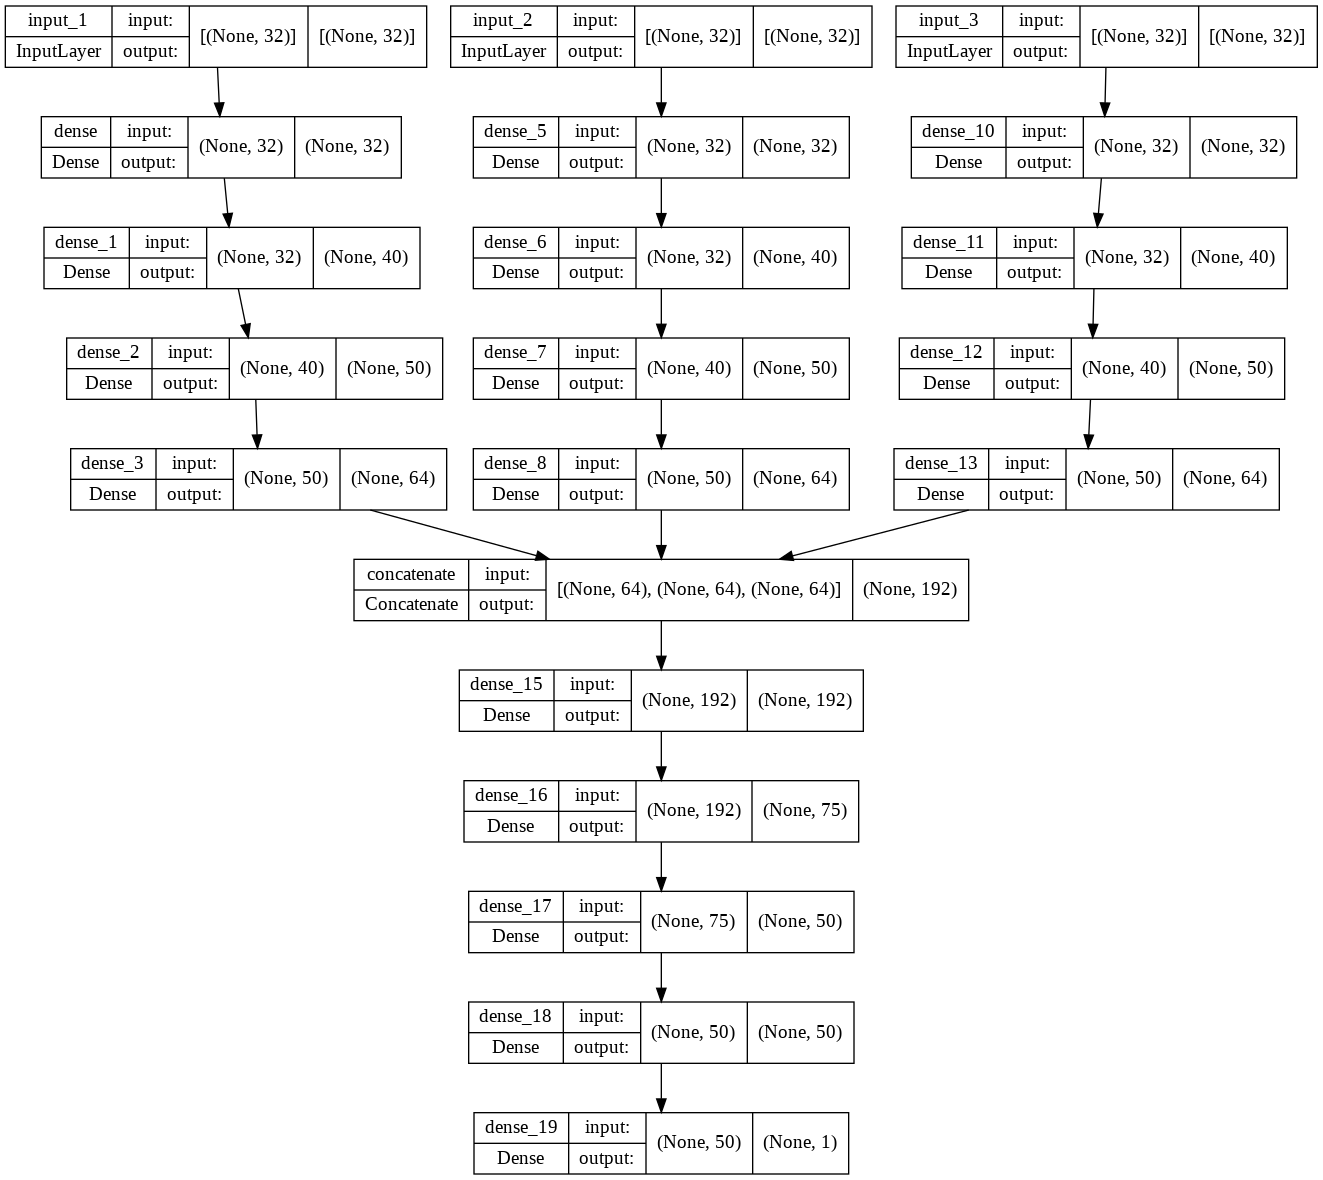

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(genres_model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Models Training:
if os.path.exists('models/') != True: 
    os.mkdir('models/')

# Generating the datasets:
genres_like, genres_dislike, genres_movie, rf_input, ratings = merge_shuffle_split() # Default split of the whole ratings.csv dataset is set to be 50%; already shuffled

train_split = 0.5 ## This would be about 25% of original ratings.csv dataset
split_index = int(len(ratings) * train_split)

genres_like_train = genres_like.iloc[: split_index, :]
genres_like_test = genres_like.iloc[split_index :, :]
del genres_like ## Attempting to save RAM space

genres_dislike_train = genres_dislike.iloc[: split_index, :]
genres_dislike_test = genres_dislike.iloc[split_index :, :]
del genres_dislike

genres_movie_train = genres_movie.iloc[: split_index, :]
genres_movie_test = genres_movie.iloc[split_index :, :]
del genres_movie

ratings_scaled = np.array(ratings) / 5
ratings_scaled_train = ratings_scaled[: split_index]
ratings_scaled_test = ratings_scaled[split_index :]

batch_size = 500
epochs = 15

def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (5 - epoch))

Learning_Rate_Callback = keras.callbacks.LearningRateScheduler(scheduler)

class Save_Progress_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None): ## Saving and printing after each epoch
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print("Epoch {}, loss is {:7.3f}, validation loss is {:7.3f}, learning rate is {}.".format(epoch, logs["loss"], logs["val_loss"], lr))
            
### !!!!!!!!!!!!!! VERBOSE MUST BE SET TO 0 AS THE OUTPUT IS TOO LONG/LARGE AND WILL CRASH THE NOTEBOOK    
genres_model.fit(x= [genres_like_train, genres_dislike_train, genres_movie_train], 
                  y= ratings_scaled_train, 
                  epochs= epochs, verbose= 0, batch_size= batch_size, validation_split= 0.2, shuffle= True,
                  callbacks=[Learning_Rate_Callback, Save_Progress_Callback()])

genres_model.save('models/genres_model.h5', overwrite= True, include_optimizer= True)

# _____________________________________________________________________________________________________
# Tag Model, Random Forest:
rf_input_train = rf_input.iloc[: split_index, :]
rf_input_test = rf_input.iloc[split_index :, :]

ratings_train = ratings[: split_index]
ratings_test = ratings[split_index :]

random_forest = RandomForestRegressor(n_estimators= 100, max_features= 'sqrt', verbose=2, random_state= True, n_jobs= -1)
random_forest.fit(rf_input_train, ratings_train)
print(random_forest.score(rf_input_test, ratings_test))

# Saving RF model:
pickle.dump(random_forest, open('tags_model.sav', 'wb'))


genres_model_predictions = (genres_model.predict(x= [genres_like_test, genres_dislike_test, genres_movie_test])) * 5 # Rescale back to original values
random_forest_predict = random_forest.predict(rf_input_test)

print('genres Model Stats:')
stats(genres_model_predictions, ratings_scaled_test * 5)
print('Tags Model Stats:')
stats(random_forest_predict, ratings_test)

# Creating a input for the combine_model:
genres_model_predictions_list = []

for prediction in genres_model_predictions:
    genres_model_predictions_list.append(prediction[0])
    
merged_predictions = pd.DataFrame({'genres_model': genres_model_predictions_list, 
                                   'tag_model': list(random_forest_predict), 
                                   'genres_true': list(np.array(list(ratings_scaled_test)) * 5), 
                                   'tag_true': ratings_test}, 
                                  index= list(range(len(ratings_test))))

# Using a linear regression for predictions adjustment:
X = merged_predictions.loc[:, ['genres_model', 'tag_model']]
y = np.array(merged_predictions.loc[:, 'genres_true']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

#line_reg = LinearRegression(n_jobs= -1).fit(X_train, y_train)
#print('\n\n\n\nLinear Regression R2:', line_reg.score(X_test, y_test))
#line_reg_predictions = line_reg.predict(X_test)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
line_reg = LinearRegression(n_jobs= -1).fit(X_train, y_train)
print('Polynomial Regression R2:', line_reg.score(X_test, y_test))
line_reg_predictions = line_reg.predict(X_test)


# Saving linear regression model:
pickle.dump(line_reg, open('combine_model.sav', 'wb'))

# Rounding the predictions that are out of bounds:
line_reg_predictions_rounded = []

for prediction in line_reg_predictions:
    rounded = prediction
    if rounded > 5:
        rounded = 5
    elif rounded < 0.5:
        rounded = 0.5
    
    line_reg_predictions_rounded.append(rounded)
        

stats(line_reg_predictions_rounded, y_test)

Epoch 0, loss is   0.043, validation loss is   0.157, learning rate is 0.0010000000474974513.
Epoch 1, loss is   0.043, validation loss is   0.160, learning rate is 0.0010000000474974513.
Epoch 2, loss is   0.042, validation loss is   0.163, learning rate is 0.0010000000474974513.
Epoch 3, loss is   0.042, validation loss is   0.166, learning rate is 0.0010000000474974513.
Epoch 4, loss is   0.041, validation loss is   0.170, learning rate is 0.0010000000474974513.
Epoch 5, loss is   0.040, validation loss is   0.174, learning rate is 0.0010000000474974513.
Epoch 6, loss is   0.040, validation loss is   0.178, learning rate is 0.0009048373904079199.
Epoch 7, loss is   0.039, validation loss is   0.182, learning rate is 0.0008187307394109666.
Epoch 8, loss is   0.039, validation loss is   0.185, learning rate is 0.0007408182136714458.
Epoch 9, loss is   0.038, validation loss is   0.188, learning rate is 0.0006703200633637607.
Epoch 10, loss is   0.038, validation loss is   0.191, learn

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100building tree 10 of 100

building tree 11 of 100building tree 12 of 100

building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100building tree 21 of 100

building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100building tree 26 of 100

building tree 27 of 100
building tree 28 of 100building tree 29 of 100

building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100

building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


-0.3141445378151262
genres Model Stats:
True Positive: 0, True Negative: 10, False Positive 0, False Negative 6
Rating Accuracy: 0.3125, Catagorical Accuracy (Like/Dislike) 0.625
------------------------------------------------------------------------------------------------------------
Tags Model Stats:
True Positive: 0, True Negative: 9, False Positive 1, False Negative 6
Rating Accuracy: 0.3125, Catagorical Accuracy (Like/Dislike) 0.5625
------------------------------------------------------------------------------------------------------------
Polynomial Regression R2: -0.8081658285718125
True Positive: 1, True Negative: 2, False Positive 1, False Negative 0
Rating Accuracy: 0.75, Catagorical Accuracy (Like/Dislike) 0.75
------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
import sys
  
  
print("User Current Version:-", sys.version)

User Current Version:- 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


In [ ]:
# CELL 19

def top_10_recommendations(userId):
    # Loading all the datasets needed:
    movies_df_mod = pd.read_csv('data/movies_mod.csv')
    ratings_df_removed = pd.read_csv('data/ratings_df_last_liked_movie_removed.csv')

    
    # Gathering all the movies in the dataset:
    not_watched = list(movies_df_mod.movieId)
    
    # Selecting all movies that have not been seen by the user:
    ratings_df_removed = ratings_df_removed[ratings_df_removed.userId == userId]
    
    if len(ratings_df_removed) ==  0:  ## First check for valid users/users with enough information 
        return print('User {} does not have enough information. 1'.format(userId))
    
    ratings_df_removed = ratings_df_removed.merge(movies_df_mod, how= 'left', on= 'movieId').dropna()
    
    if len(ratings_df_removed) ==  0:  ## Second check
        return print('User {} does not have enough information. 2'.format(userId))
    
    watched = list(ratings_df_removed.movieId)
    del ratings_df_removed  ## I find that not all variables are actually cleared in definitions; this is to ensure it removed from RAM
    
    # Finding the movies the user has not watched:
    for movie in watched:
        if movie in not_watched:
            not_watched.remove(movie)
            
    # Loading in users' like and disliked genres:
    total_user_like_df = pd.read_csv('data/total_user_like_df.csv')
    total_user_dislike_df = pd.read_csv('data/total_user_dislike_df.csv') 

    
    # Selecting from total_user_like_df and total_user_dislike_df to isolate only the userId input:
    total_user_like_df = total_user_like_df[total_user_like_df.userId == userId]
    
    if len(total_user_like_df) ==  0:  ## Third check
        return print('User {} does not have enough information. 3'.format(userId))
    
    total_user_dislike_df = total_user_dislike_df[total_user_dislike_df.userId == userId]
    if len(total_user_dislike_df) ==  0:  ## Fourth check
        return print('User {} does not have enough information. 4'.format(userId))
            
    # Changing the columns names to differentiate between the columns of total_user_like_df and total_user_dislike_df:

    like_columns = list(total_user_like_df.columns)
    like_columns_modified = []

    for column in like_columns:
        if column == 'userId':
            like_columns_modified.append('userId')
        else:
            modify_column = 'user_like_' + column
            like_columns_modified.append(modify_column)

    total_user_like_df.columns = like_columns_modified
    
    dislike_columns = list(total_user_dislike_df.columns)
    dislike_columns_modified = []

    for column in dislike_columns:
        if column == 'userId':
            dislike_columns_modified.append('userId')
        else:
            modify_column = 'user_dislike_' + column
            dislike_columns_modified.append(modify_column)

    total_user_dislike_df.columns = dislike_columns_modified

    # Loading in tags:
    movie_tags_df = pd.read_csv('data/final/movie_tags_df.csv')
    like_dislike_tags = (pd.read_csv('data/final/like_dislike_tags.csv')).astype('int64')
    
    # Selecting the movies that have not been seen from movie_tags_df and merging movies_df_mod and movie_tags_df:
    template_df = pd.DataFrame({'movieId': not_watched}, index= list(range(len(not_watched)))) ## Creating a template DF for merging
    template_df = template_df.merge(movies_df_mod, how= 'left', on= 'movieId').dropna()
    template_df = template_df.merge(movie_tags_df, how= 'left', on= 'movieId').dropna()
    del movie_tags_df
    
    # Selecting the user's tags:
    like_dislike_tags = like_dislike_tags[like_dislike_tags.userId == userId]
    if len(like_dislike_tags) ==  0:  ## Fifth check
        return print('User {} does not have enough information. 5'.format(userId))

    # Adding a userId column to the template DF so that merging is possible with total_user_like_df, total_user_dislike_df, and like_dislike_tags
    template_df['userId'] = userId
    template_df = template_df.merge(total_user_like_df, how= 'left', on= 'userId').dropna()
    del total_user_like_df
    template_df = template_df.merge(total_user_dislike_df, how= 'left', on= 'userId').dropna()
    del total_user_dislike_df
    template_df = template_df.merge(like_dislike_tags, how= 'left', on= 'userId').dropna()
    del like_dislike_tags
    
    like_columns_modified.remove('userId')
    dislike_columns_modified.remove('userId')
    like_columns.remove('userId')

    # Generating the columns for the tag inputs for random forest:
    rf_columns = []
    for x in range(20): 
        rf_columns.append('LIKE_' + str(x))
        rf_columns.append('DISLIKE_' + str(x))
    for x in range(5):
        rf_columns.append('TAG_' + str(x))
        
    # Selecting out the inputs from the template DF by column names:
    genres_like_input = template_df.loc[:, like_columns_modified]
    genres_dislike_input = template_df.loc[:, dislike_columns_modified]
    genres_movie_input = template_df.loc[:, like_columns]
    
    tags_input = template_df.loc[:, rf_columns]
    
    # Saving the movieId list:
    movieId_list = list(template_df.movieId)
    
    del template_df
    
    # Loading in all models
    genres_model = tf.keras.models.load_model('models/genres_model.h5', compile=True)
    tags_model = pickle.load(open('tags_model.sav', 'rb'))
    combine_model = pickle.load(open('combine_model.sav', 'rb'))
    
    # Predicting with the genres model and tags model:
    genres_model_predictions = (genres_model.predict(x= [genres_like_input, genres_dislike_input, genres_movie_input])) * 5 ## Rescaling up; predicts a scaled and bound (sigmoid, 0-1) values
    tags_model_predictions = tags_model.predict(tags_input)
    
    # Extracting and changing the Keras predictions into a 1-D format (list):
    genres_model_predictions_list = []

    for prediction in genres_model_predictions:
        genres_model_predictions_list.append(prediction[0])
    
    # Using the predictions from the two models as the inputs for the combine_model:
    combine_input = pd.DataFrame({'genres_predictions': genres_model_predictions_list, 
                                  'tags_predictions': tags_model_predictions}, 
                                 index= list(range(len(genres_model_predictions))))
    
    combine_model_predictions = combine_model.predict(combine_input)
    
    # Rounding the predictions that are out of bounds:
    combine_model_predictions_rounded = []

    for prediction in combine_model_predictions:
        rounded = prediction
        if rounded > 5:
            rounded = 5
        elif rounded < 0.5:
            rounded = 0.5

        combine_model_predictions_rounded.append(rounded)
    
    # Adding all predictions into one DF:
    predictions_df = pd.DataFrame({'movieId': movieId_list,
                                   'genres_predictions': genres_model_predictions_list, 
                                  'tags_predictions': tags_model_predictions,
                                  'combine_predictions': combine_model_predictions_rounded}, 
                                 index= list(range(len(movieId_list))))
    
    # Sorting by combine_model_predictions_rounded and selecting the first 10 highest predicted ratings:
    best_movies_df = predictions_df.sort_values(by= ['combine_predictions'], ascending=False).iloc[:10, :]
    
    # Finding adding the movie titles and information to highest 10:
    best_movies_df = best_movies_df.merge(movies_df_mod, how= 'left', on= 'movieId').dropna()
    del movies_df_mod
    
    return predictions_df, best_movies_df
    
    

In [ ]:
# CELL 20

predictions_df, best_movies_df = top_10_recommendations(1) 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- genres_predictions
- tags_predictions
Feature names seen at fit time, yet now missing:
- genres_model
- tag_model

  warnings.warn(message, FutureWarning)


In [ ]:
# CELL 21

predictions_df

,movieId,genres_predictions,tags_predictions,combine_predictions
0,1,3.988985,4.005,3.913446
1,2,3.819131,3.810,3.684907
2,3,4.143332,3.595,3.870928
3,4,4.228648,3.330,3.831076
4,5,3.864596,3.965,3.789883
...,...,...,...,...
11327,205287,4.260512,3.580,3.964883
11328,205383,4.230247,3.935,4.090224
11329,205425,3.864596,3.815,3.725971
11330,206845,4.229108,3.555,3.927338


In [ ]:
# CELL 22

best_movies_df

,movieId,genres_predictions,tags_predictions,combine_predictions,title,genres,YEAR,UPPER_STD,LOWER_STD,AVG_RATING,...,Musical,Mystery,Crime,Children,Animation,Sci-Fi,Adventure,Western,Horror,None
0,6567,4.608939,4.240,4.544469,Buffalo Soldiers (2001),Comedy|Crime|Drama|War,2001,4.485825,2.605084,3.545455,...,0,0,1,0,0,0,0,0,0,0
1,1148,4.633185,3.965,4.448060,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime,1993,5.000000,3.229959,4.148876,...,0,0,1,1,1,0,0,0,0,0
2,56060,4.484933,4.240,4.438277,I Served the King of England (Obsluhoval jsem ...,Comedy|Drama|Romance|War,2006,4.616927,3.549740,4.083333,...,0,0,0,0,0,0,0,0,0,0
3,79091,4.633185,3.940,4.437408,Despicable Me (2010),Animation|Children|Comedy|Crime,2010,4.755651,2.816513,3.786082,...,0,0,1,1,1,0,0,0,0,0
4,7118,4.612813,3.920,4.411440,Wings of Honneamise (Ôritsu uchûgun Oneamisu n...,Animation|Drama|Sci-Fi|War,1987,4.578689,3.087977,3.833333,...,0,0,0,0,1,1,0,0,0,0
5,5689,4.397862,4.345,4.408453,Billy Bathgate (1991),Crime|Drama,1991,3.957427,2.042573,3.000000,...,0,0,1,0,0,0,0,0,0,0
6,3328,4.397862,4.335,4.404192,Ghost Dog: The Way of the Samurai (1999),Crime|Drama,1999,4.655128,3.011538,3.833333,...,0,0,1,0,0,0,0,0,0,0
7,163931,4.420132,4.290,4.404089,Billy Lynn's Long Halftime Walk (2016),Drama|War,2016,3.500000,3.500000,3.500000,...,0,0,0,0,0,0,0,0,0,0
8,8690,4.543261,4.025,4.396619,Slaughterhouse-Five (1972),Comedy|Drama|Sci-Fi|War,1972,4.573960,2.579886,3.576923,...,0,0,0,0,0,1,0,0,0,0
9,7919,4.383518,4.340,4.394039,Drunken Angel (Yoidore tenshi) (1948),Drama|Film-Noir,1948,4.163818,1.436182,2.800000,...,0,0,0,0,0,0,0,0,0,0
